In [17]:
using CSV
using DataFrames
using Dates
using StatsPlots
using Statistics
using Temporal
using GLM
using TimeSeries: TimeArray 
using StatsBase
using StatsPlots

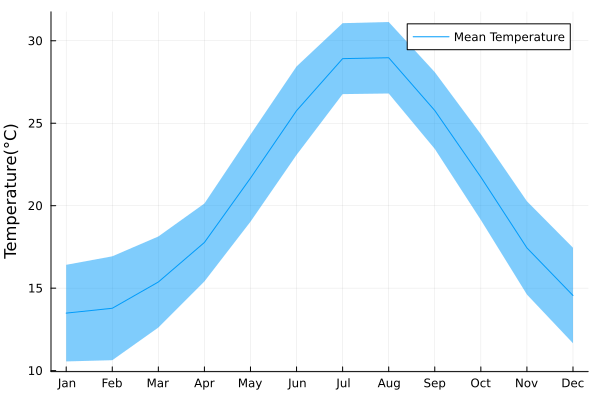

In [12]:
df = CSV.read("data_tx/BASTIA.txt", DataFrame, skipto = 22, header = 21, comment="#",dateformat = "yyyymmdd", types=Dict(:DATE => Date), normalizenames=true)

factor = 0.1 # conversion factor to °C
df_month = @chain df begin
    @subset(:Q_TX .!= 9) # remove missing 
    @transform(:MONTH = month.(:DATE)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:TX)*factor, :MONTHLY_STD = std(:TX)*factor) # grouby MONTH + takes the mean/std in each category 
end


@df df_month plot(monthabbr.(1:12), :MONTHLY_MEAN, ribbon = :MONTHLY_STD, label = "Mean Temperature")
ylabel!("Temperature(°C)")

In [13]:
# Charger les données
df = CSV.read("data_tx/LYON.txt", DataFrame, skipto = 22, header = 21, comment="#", dateformat = "yyyymmdd", types=Dict(:DATE => Date), normalizenames=true)

# Filtrer les données entre 1970 et 2006
df_filtered = filter(row -> year(row.DATE) >= 1970 && year(row.DATE) <= 2006, df)

# Conversion factor to °C
factor = 0.1

# Calculer la moyenne et l'écart type pour chaque date
df_daily = @chain df_filtered begin
    @subset(:Q_TX .!= 9) # Supprimer les valeurs manquantes 
    @transform(:YEAR = year.(:DATE)) # Ajouter une colonne pour l'année
    @by(:DATE, :DAILY_MEAN = mean(:TX)*factor, :DAILY_STD = std(:TX)*factor) # Grouper par DATE et prendre la moyenne / écart type
end
# Convertir les données en une série temporelle avec TimeSeries
my_ts = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)

# Extraire les valeurs numériques de la série temporelle
data_values = values(my_ts)

# Calculer l'autocorrélogramme partiel avec un nombre maximal de décalages spécifié
maxlag = 50 # Définir le nombre maximal de décalages
lags = collect(0:maxlag) # Créer une plage de décalages
pacf_values = pacf(data_values, lags)


51-element Vector{Float64}:
  1.0
  0.9246263192767535
  0.07813787796351192
  0.14130430309830264
  0.09947575558678673
  0.08485540617157925
  0.07150420690537192
  0.04149794975821931
  0.06378529541180604
  0.05026966354994905
  ⋮
  0.0019437813209482254
 -0.018548963586745383
 -0.009284093874506922
 -0.01617828707664294
 -0.026513184116565367
 -0.007576907407667528
 -0.010112653373667546
 -0.01158419381563495
 -0.02552153939092528

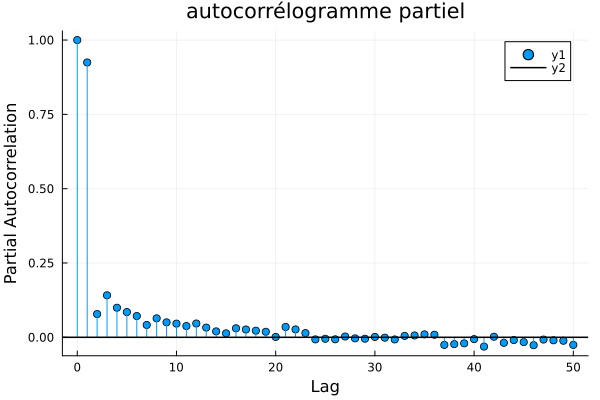

In [14]:
plot(0:maxlag, pacf_values, xlabel="Lag", ylabel="Partial Autocorrelation", title="autocorrélogramme partiel", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5)

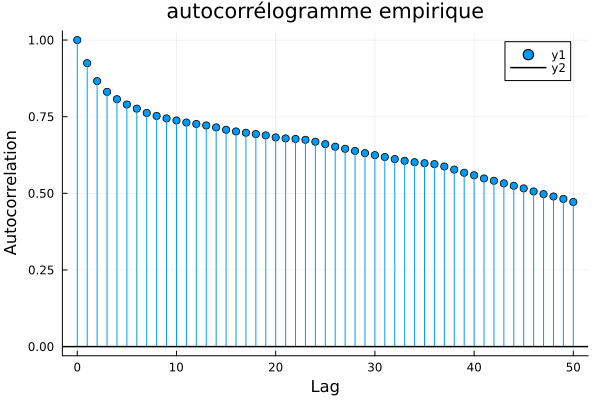

In [15]:
autocor_values = autocor(data_values, lags)

# Tracer l'autocorrélogramme empirique avec les points reliés à l'axe des abscisses et une droite d'équation nulle
plot(0:maxlag, autocor_values, xlabel="Lag", ylabel="Autocorrelation", title="autocorrélogramme empirique", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5)

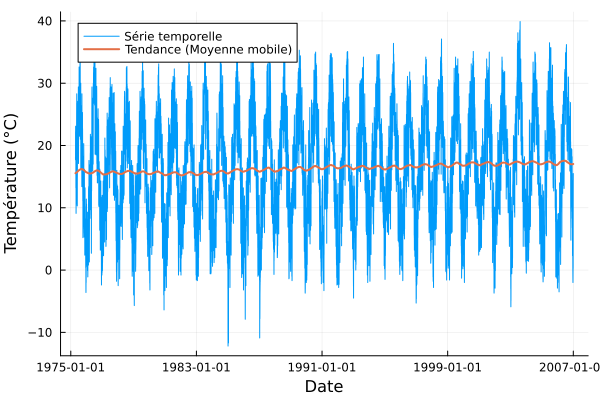

In [16]:
function moyenne_mobile(data::Vector{T}, window_size::Int) where T
    n = length(data)
    trend = similar(data, T)
    for i in 1:n
        start_idx = max(1, i - window_size ÷ 2)
        end_idx = min(n, i + window_size ÷ 2)
        trend[i] = mean(@view(data[start_idx:end_idx]))
    end
    return trend
end

# Calculer la tendance par moyenne mobile avec une fenêtre de taille 5000 (par exemple)
trend_values = moyenne_mobile(df_daily.DAILY_MEAN, 3000)

# Convertir les données en une série temporelle
datats = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)

# Tracer la série temporelle avec la tendance
plot(datats, label="Série temporelle", xlabel="Date", ylabel="Température (°C)", legend=:topleft)
plot!(df_daily.DATE, trend_values, label="Tendance (Moyenne mobile)", linewidth=2)


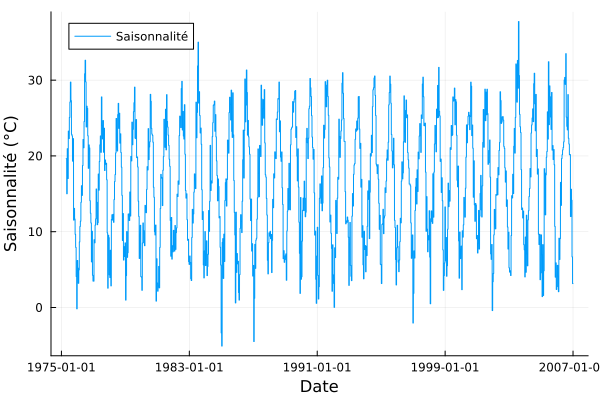

In [20]:

function saisonnalite(data::Vector{T}, period::Int) where T
    n = length(data)
    seasonal = similar(data, T) # Vecteur de la même taille et du meme type que data 
    seasonal_count = Int(ceil(n / period))
    
    seasonal_avg = similar(data, T)
    for i in 1:seasonal_count
        start_idx = (i - 1) * period + 1
        end_idx = min(i * period, n)
        seasonal_avg[start_idx:end_idx] .= mean(@view(data[start_idx:end_idx]))
    end
    
    for i in 1:n
        seasonal[i] = seasonal_avg[i]
    end
    
    return seasonal
end

# Calculer la saisonnalité avec une période saisonnière de 12 mois (par exemple)
seasonal_values = saisonnalite(df_daily.DAILY_MEAN, 12)

# Tracer la série temporelle de la saisonnalité
plot(df_daily.DATE, seasonal_values, label="Saisonnalité", xlabel="Date", ylabel="Saisonnalité (°C)")






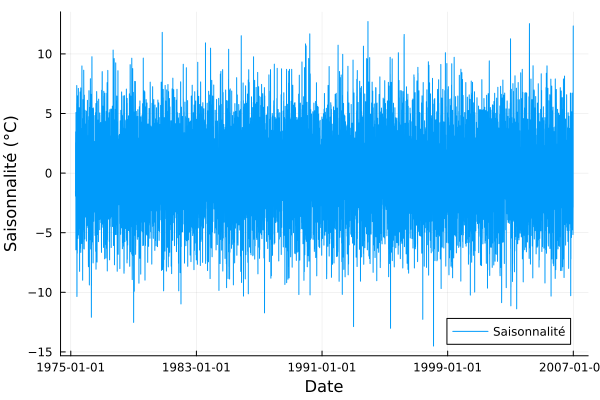

In [19]:

function retiresaisonnalite(data::Vector{T}, period::Int) where T
    n = length(data)
    seasonal = similar(data, T)
    seasonal_count = Int(ceil(n / period))
    
    seasonal_avg = similar(data, T)
    for i in 1:seasonal_count
        start_idx = (i - 1) * period + 1
        end_idx = min(i * period, n)
        seasonal_avg[start_idx:end_idx] .= mean(@view(data[start_idx:end_idx]))
    end
    
    for i in 1:n
        seasonal[i] = data[i] - seasonal_avg[i]
    end
    
    return seasonal
end

# Calculer la saisonnalité avec une période saisonnière de 12 mois (par exemple)
seasonal_values = retiresaisonnalite(df_daily.DAILY_MEAN, 12)


# Tracer la série temporelle de la saisonnalité
plot(df_daily.DATE, seasonal_values, label="Saisonnalité", xlabel="Date", ylabel="Saisonnalité (°C)")